In [2]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [3]:
df_no_diagnosis = pd.read_csv(
    './data/respiratory-sound-database/demographic_info.txt', 
    names = ['Patient number', 'Age', 'Sex', 'Adult BMI (kg/m2)', 'Child Weight (kg)', 'Child Height (cm)'],
    delimiter=' '
)

diagnosis = pd.read_csv(
    './data/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',
    names=['Patient number', 'Diagnosis']
)


In [4]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [5]:
# If your current working directory is "lung-disease-prediction/", then:
root = "./data/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"

# List all files in that directory to verify
all_files = os.listdir(root)
print("All files in directory:", all_files)

# Generate filenames list by capturing the base name (without '.txt')
filenames = [s.split('.')[0] for s in os.listdir(path=root) if s.endswith('.txt')]
print("Filenames (base, no extension):", filenames)

All files in directory: ['101_1b1_Al_sc_Meditron.txt', '101_1b1_Al_sc_Meditron.wav', '101_1b1_Pr_sc_Meditron.txt', '101_1b1_Pr_sc_Meditron.wav', '102_1b1_Ar_sc_Meditron.txt', '102_1b1_Ar_sc_Meditron.wav', '103_2b2_Ar_mc_LittC2SE.txt', '103_2b2_Ar_mc_LittC2SE.wav', '104_1b1_Al_sc_Litt3200.txt', '104_1b1_Al_sc_Litt3200.wav', '104_1b1_Ar_sc_Litt3200.txt', '104_1b1_Ar_sc_Litt3200.wav', '104_1b1_Ll_sc_Litt3200.txt', '104_1b1_Ll_sc_Litt3200.wav', '104_1b1_Lr_sc_Litt3200.txt', '104_1b1_Lr_sc_Litt3200.wav', '104_1b1_Pl_sc_Litt3200.txt', '104_1b1_Pl_sc_Litt3200.wav', '104_1b1_Pr_sc_Litt3200.txt', '104_1b1_Pr_sc_Litt3200.wav', '105_1b1_Tc_sc_Meditron.txt', '105_1b1_Tc_sc_Meditron.wav', '106_2b1_Pl_mc_LittC2SE.txt', '106_2b1_Pl_mc_LittC2SE.wav', '106_2b1_Pr_mc_LittC2SE.txt', '106_2b1_Pr_mc_LittC2SE.wav', '107_2b3_Al_mc_AKGC417L.txt', '107_2b3_Al_mc_AKGC417L.wav', '107_2b3_Ar_mc_AKGC417L.txt', '107_2b3_Ar_mc_AKGC417L.wav', '107_2b3_Ll_mc_AKGC417L.txt', '107_2b3_Ll_mc_AKGC417L.wav', '107_2b3_Lr_mc_

In [6]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [11]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,224,1b2,Al,sc,Meditron
0,225,1b1,Pl,sc,Meditron
0,226,1b1,Al,sc,Meditron
0,226,1b1,Ll,sc,Meditron
0,226,1b1,Pl,sc,LittC2SE


In [12]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [13]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

,filename
0,101_1b1_Al_sc_Meditron
1,101_1b1_Pr_sc_Meditron
2,102_1b1_Ar_sc_Meditron
3,103_2b2_Ar_mc_LittC2SE
4,104_1b1_Al_sc_Litt3200
...,...
915,224_1b2_Al_sc_Meditron
916,225_1b1_Pl_sc_Meditron
917,226_1b1_Al_sc_Meditron
918,226_1b1_Ll_sc_Meditron


In [14]:
audio_path = "./data/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"

In [15]:
# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment
#file_label_df['duration'] = duration
#file_label_df['sample rate'] = sample_rate

  0%|          | 0/920 [00:00<?, ?it/s]

In [16]:
file_label_df

,filename,Diagnosis,Patient Number,Chest Location,Acquisition Mode,Recording Equipment
0,101_1b1_Al_sc_Meditron,URTI,101,Al,sc,Meditron
1,101_1b1_Pr_sc_Meditron,URTI,101,Pr,sc,Meditron
2,102_1b1_Ar_sc_Meditron,Healthy,102,Ar,sc,Meditron
3,103_2b2_Ar_mc_LittC2SE,Asthma,103,Ar,mc,LittC2SE
4,104_1b1_Al_sc_Litt3200,COPD,104,Al,sc,Litt3200
...,...,...,...,...,...,...
915,224_1b2_Al_sc_Meditron,Healthy,224,Al,sc,Meditron
916,225_1b1_Pl_sc_Meditron,Healthy,225,Pl,sc,Meditron
917,226_1b1_Al_sc_Meditron,Pneumonia,226,Al,sc,Meditron
918,226_1b1_Ll_sc_Meditron,Pneumonia,226,Ll,sc,Meditron


In [17]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('normal')

file_label_df['3 label diagnosis'] = diagnosis_3

In [18]:
file_label_df

,filename,Diagnosis,Patient Number,Chest Location,Acquisition Mode,Recording Equipment,3 label diagnosis
0,101_1b1_Al_sc_Meditron,URTI,101,Al,sc,Meditron,Non-Chronic Disease
1,101_1b1_Pr_sc_Meditron,URTI,101,Pr,sc,Meditron,Non-Chronic Disease
2,102_1b1_Ar_sc_Meditron,Healthy,102,Ar,sc,Meditron,normal
3,103_2b2_Ar_mc_LittC2SE,Asthma,103,Ar,mc,LittC2SE,Chronic Disease
4,104_1b1_Al_sc_Litt3200,COPD,104,Al,sc,Litt3200,Chronic Disease
...,...,...,...,...,...,...,...
915,224_1b2_Al_sc_Meditron,Healthy,224,Al,sc,Meditron,normal
916,225_1b1_Pl_sc_Meditron,Healthy,225,Pl,sc,Meditron,normal
917,226_1b1_Al_sc_Meditron,Pneumonia,226,Al,sc,Meditron,Non-Chronic Disease
918,226_1b1_Ll_sc_Meditron,Pneumonia,226,Ll,sc,Meditron,Non-Chronic Disease


In [19]:
file_label_df['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

# Exploratory Data Analysis 

In [20]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [21]:
i = 100
sound_filename = audio_path + file_label_df['filename'][i] + '.wav'

In [22]:
import IPython.display as ipd
ipd.Audio(sound_filename, rate=16000)

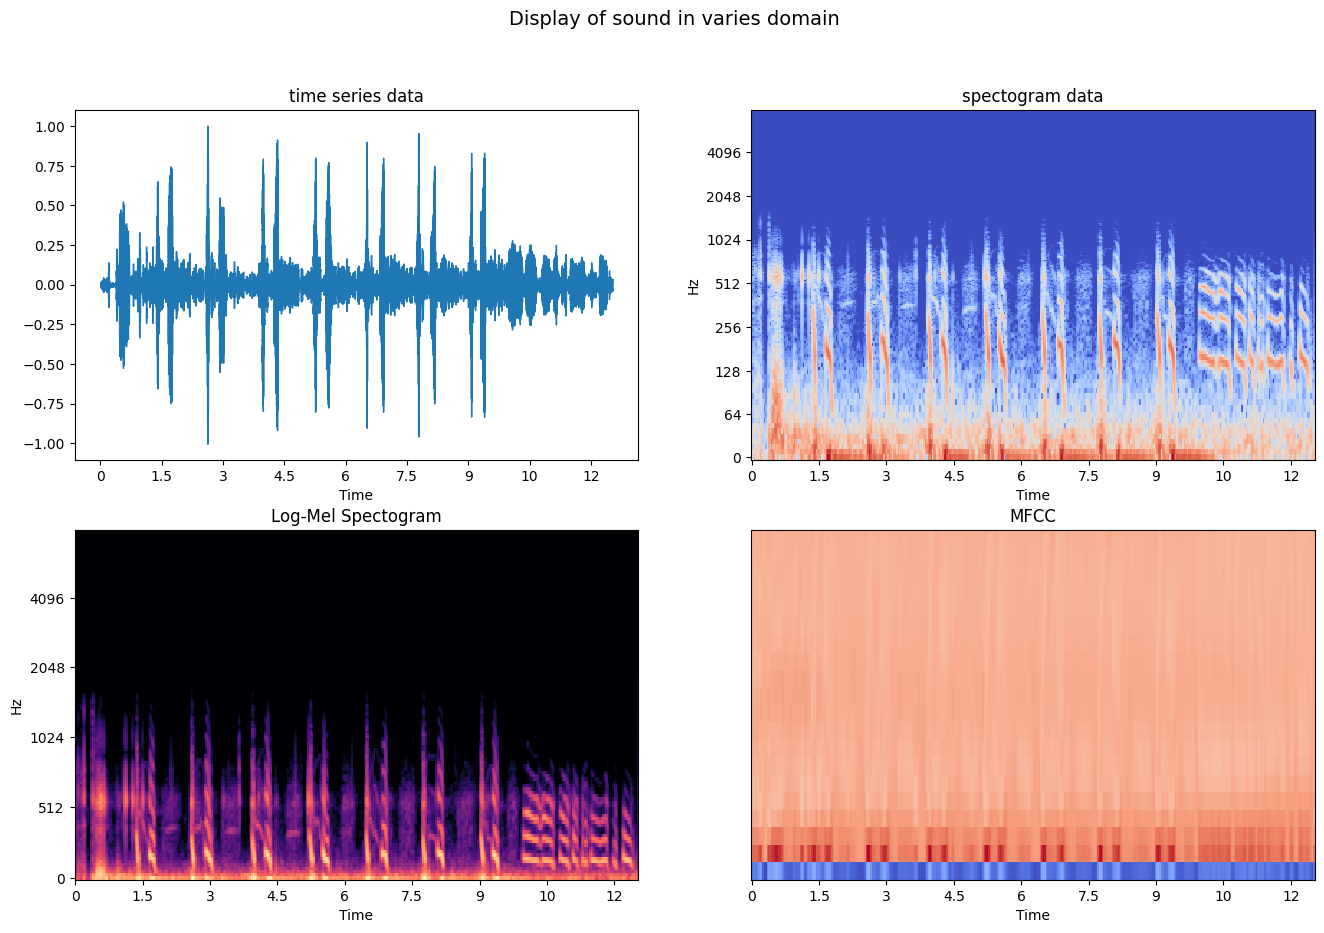

In [23]:
# Displaying sound data 
"""
  time series : amplitude of sound is varied in time domain (1D)
  spectogram : amplitude of sound is varied in time and frequency domain (2D)
"""
# time series data
sr_new = 16000 # resample 16 kHz
x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

# Spectogram data 
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectogram
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)


# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(y=x, sr=sr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='time series data')

librosa.display.specshow(Xdb, x_axis='time',
                         y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='spectogram data')

librosa.display.specshow(log_mel, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectogram')


librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Display of sound in varies domain", fontsize=14);


# Preprocessing

In [24]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound 
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]
    
    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)
    
    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)
    

    return feature

In [25]:
# apply preprocessing to sound data

labels = []
labels_3 = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  #labels_3.append(file_label_df['3 label diagnosis'][i])
  audio_file = audio_path + file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
labels_3 = np.array(labels_3)



  0%|          | 0/920 [00:00<?, ?it/s]

In [26]:
preprocessed_data[0].shape

(20, 157)

In [27]:
# Reshape data to suit input of model
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [28]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=8) 

#encoder_3 = LabelEncoder()
#i_labels_3 = encoder_3.fit_transform(labels_3)
#oh_labels_3 = to_categorical(i_labels_3) 

In [29]:
oh_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [30]:
type(oh_labels)

numpy.ndarray

In [31]:
print(list(encoder.classes_))

['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


## Highly Imbalance Dataset ##

In [32]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 6440
Value: 1.0, Count: 920


In [33]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [34]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  736
size of testing set=  184


In [35]:
oh_labels.shape

(920, 8)

# Training and Testing

## Without miniority class upsampling ##

In [36]:

num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

model.summary()

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 19, 156, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9, 78, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 77, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4, 38, 64)      │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 37, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [38]:
y_train[1].shape

(8,)

In [39]:
# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6745 - loss: 2.3774
Epoch 1: val_accuracy improved from -inf to 0.81081, saving model to mymodel2_01.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.6811 - loss: 2.3502 - val_accuracy: 0.8108 - val_loss: 1.3679
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8277 - loss: 1.3707
Epoch 2: val_accuracy improved from 0.81081 to 0.82432, saving model to mymodel2_02.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.8275 - loss: 1.3546 - val_accuracy: 0.8243 - val_loss: 0.9166
Epoch 3/300
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8760 - loss: 0.6829
Epoch 3: val_accuracy did not improve from 0.82432
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8725 - loss: 0.6963 - val_accuracy: 0.8243 - val_loss: 0.8710
Epoch 4/300
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8670 - loss: 0.6691
Epoch 4: val_accuracy did not improve from 0.82432
11/11 ━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

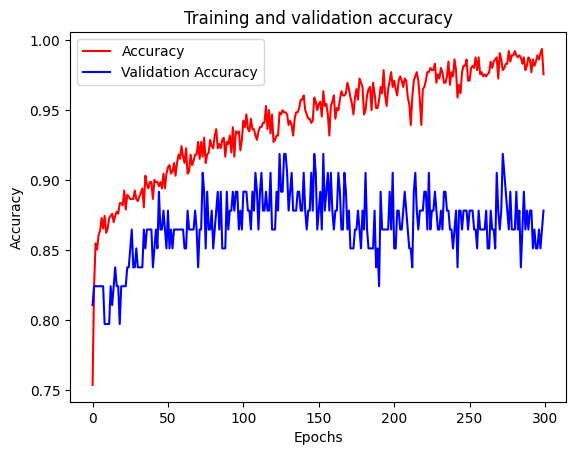

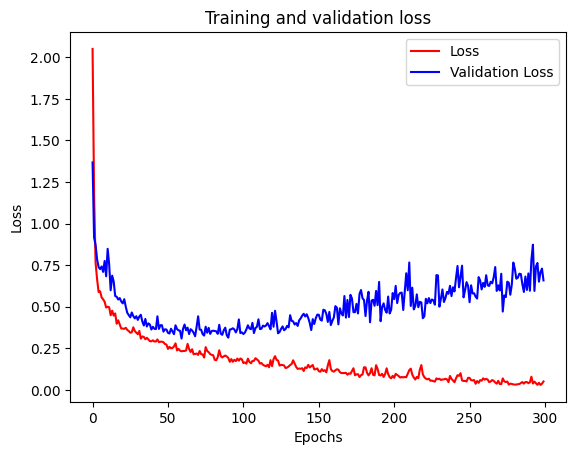

<Figure size 640x480 with 0 Axes>

In [40]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [41]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9836956262588501
Testing Accuracy:  0.8586956262588501


In [42]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=8 # number of classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


In [43]:
encoder.classes_

array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype='<U14')

In [44]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

c_names = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI']

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


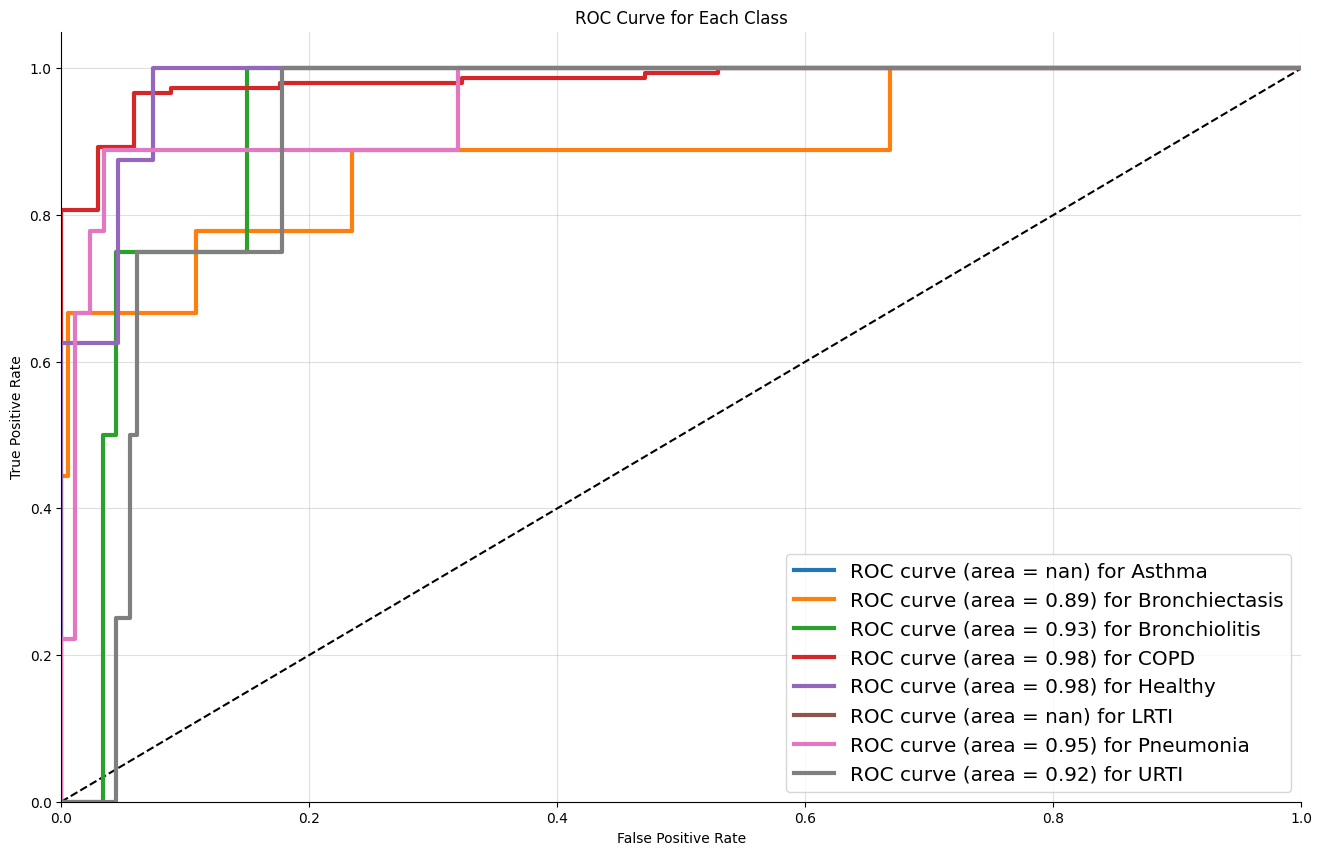

In [45]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [46]:
c_names

['Asthma',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Healthy',
 'LRTI',
 'Pneumonia',
 'URTI']

In [48]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[  2   2   4   1   0   0]
 [  0   0   1   1   0   2]
 [  0   1 149   0   0   0]
 [  0   0   1   5   0   2]
 [  0   1   6   0   2   0]
 [  0   0   2   2   0   0]]


## second approach (fixing class imbalance) ##

In [49]:
preprocessed_data.shape

(920, 20, 157, 1)

In [50]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np



n_samples, height, width, channels = preprocessed_data.shape
X_reshaped = preprocessed_data.reshape(n_samples, -1)

# Instantiate RandomOverSampler
random_oversampler = RandomOverSampler()

# Upsample the minority class using RandomOverSampler
X_resampled, y_resampled = random_oversampler.fit_resample(X_reshaped, oh_labels)
X_restored = X_resampled.reshape(-1, 20, 157, 1)


# Check the shape of the resampled data
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)


Shape of X_resampled: (6344, 3140)
Shape of y_resampled: (6344, 8)


In [51]:
X_restored.shape

(6344, 20, 157, 1)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X_restored, y_resampled, stratify=y_resampled, 
                                                    test_size=0.2, random_state = 42)

In [53]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  5075
size of testing set=  1269


In [54]:

num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns,num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel3_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 19, 156, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9, 78, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 77, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4, 38, 64)      │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 37, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1708 - loss: 4.3907
Epoch 1: val_accuracy improved from -inf to 0.46850, saving model to mymodel3_01.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.1717 - loss: 4.3664 - val_accuracy: 0.4685 - val_loss: 1.7400
Epoch 2/300
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4174 - loss: 1.6136
Epoch 2: val_accuracy did not improve from 0.46850
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.4185 - loss: 1.6113 - val_accuracy: 0.4606 - val_loss: 1.5524
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5389 - loss: 1.3311
Epoch 3: val_accuracy improved from 0.46850 to 0.49409, saving model to mymodel3_03.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.5392 - loss: 1.3304 - val_accuracy: 0.4941 - val_loss: 1.2757
Epoch 4/300
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5740 - loss: 1.1760
Epoch 4: val_accuracy improved from 0.49409 to 0.57874, saving model to m

<Figure size 640x480 with 0 Axes>

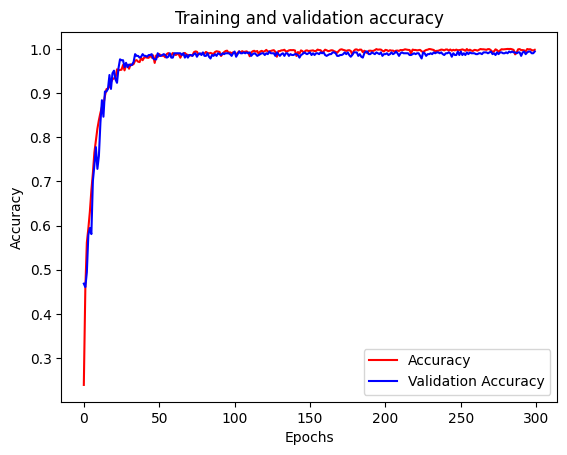

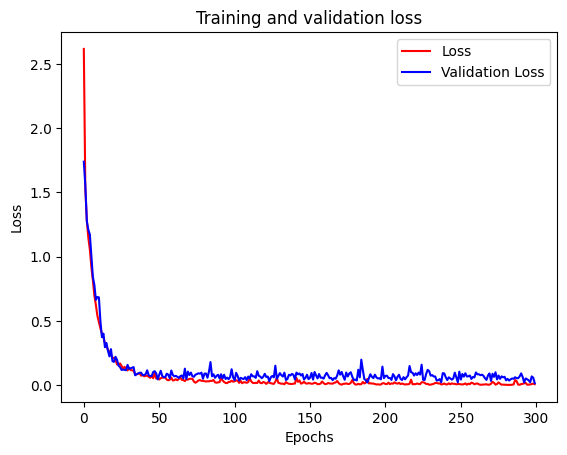

<Figure size 640x480 with 0 Axes>

In [55]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [56]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9994088411331177
Testing Accuracy:  0.9992119669914246


In [57]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=8 # number of classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [58]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



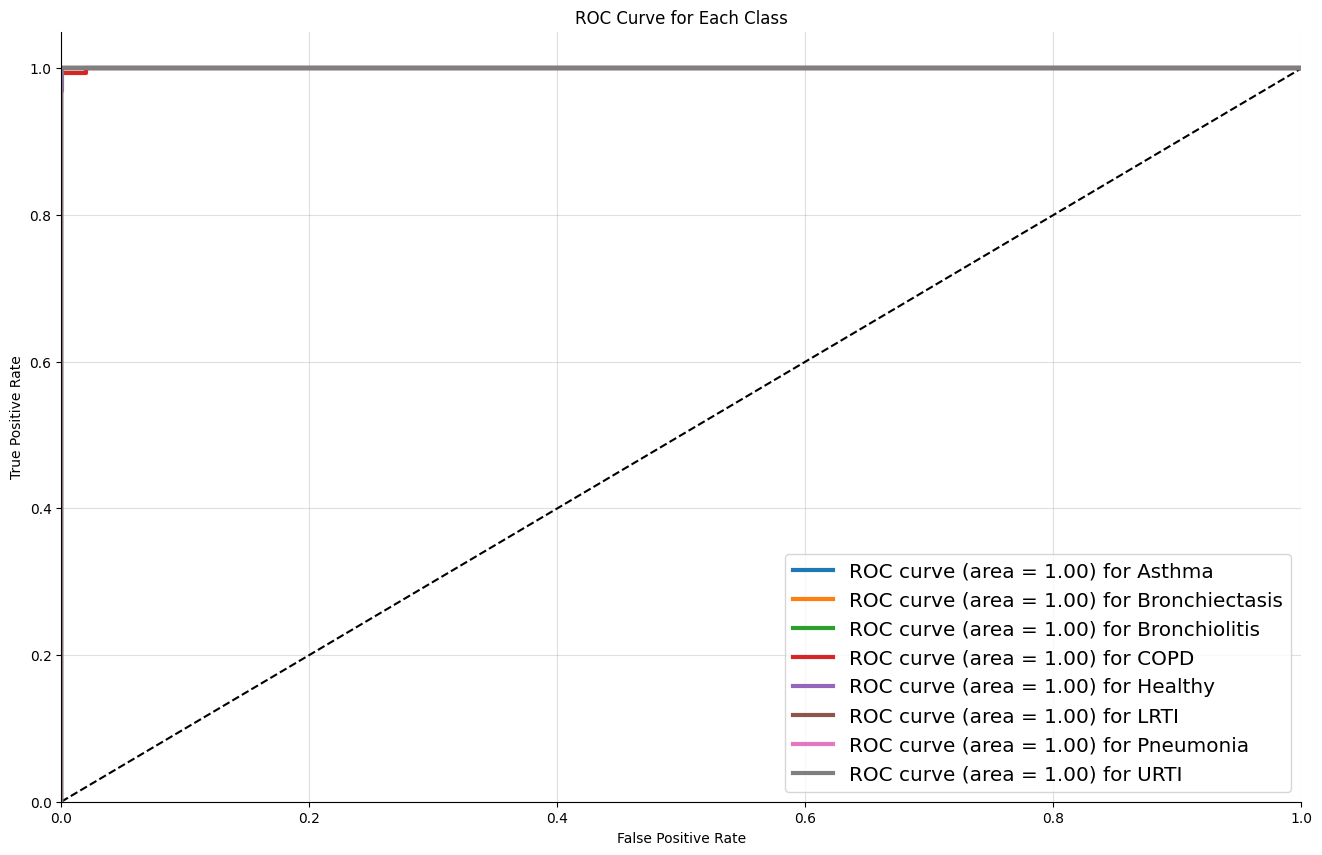

In [59]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [60]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00       159
Bronchiectasis       1.00      1.00      1.00       159
 Bronchiolitis       1.00      1.00      1.00       158
          COPD       1.00      0.99      1.00       159
       Healthy       0.99      1.00      1.00       159
          LRTI       1.00      1.00      1.00       159
     Pneumonia       1.00      1.00      1.00       158
          URTI       1.00      1.00      1.00       158

      accuracy                           1.00      1269
     macro avg       1.00      1.00      1.00      1269
  weighted avg       1.00      1.00      1.00      1269



In [61]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[159   0   0   0   0   0   0   0]
 [  0 159   0   0   0   0   0   0]
 [  0   0 158   0   0   0   0   0]
 [  0   0   0 158   1   0   0   0]
 [  0   0   0   0 159   0   0   0]
 [  0   0   0   0   0 159   0   0]
 [  0   0   0   0   0   0 158   0]
 [  0   0   0   0   0   0   0 158]]


Save model as saved model format

In [68]:
export_dir = "models/my_model.keras"

# This saves the model in the TensorFlow SavedModel format by default:
model.save(export_dir)

# Then reload:
loaded_model = tf.keras.models.load_model(export_dir)

In [69]:
# saving model in HDF5 format
model.save('prediction_lung_disease_model.keras')